**Information Overload Problem statement**: The evergrowing information in industry such as e-commerce (e.g., Amazon), entertainment (e.g.,Netflix, Sportify), social network (e.g., Linkedin), housing (e.g, Zillow, Airbnb) has called for the need to create better recommender systems for helping consumers discover new and more relevant products/items/jobs. So far, content-based recommendations, collaborative filtering have been widely used in the industry. In recent years, deep learning embedding has also garnered interest by bringing the advantage of flexibility compared to matrix factorization to the table. 

**For this project**:
In this jupyter notebook, I present the preliminary exploratory data analysis [1.1-1.4] on the 20 million movie dataset (ratings.csv and movies.csv) I want to focus on for the TDI project. I also explored and compared a few collaborative filtering approaches performed on the 1M movies as a demonstration. From my preliminary data analysis, there are 26744 unique movies, 138493 unique customers in the 20M-MovieLens dataset, with a sparsity of 0.5%; there are 9724 unique movies and 610 unique users.

A ratings matrix with users and rating as columns, and rating as values is built for the 1M-MovieLens dataset. Collaborative filtering (CF) has been used to build recommendation systems for movie rating prediction. The first step focused on improving the effectiveness of CF. 

Neighborhood-based(user-based) collaborative filtering with K-NN collaborative filter is carried out on the entire dataset, and Pearson coefficient is used to characterize similarity between the rating vectors of users. Using 10-fold cross-validation, k=30 is selected as the best k for further analysis based on RMSE and MAE values. Filter's performance for predicitng movies in trimmed test set (popular, unpopular, high variance rating movies) is evaluated in 1.6-1.8 and performance evaluation for the K-NN filter using ROC curve is in 1.9. Setting threshold as 3 gives the highest AUC value.

One type of the model-based (latent factor) collaborative filtering --NNMF-- is implemented to predict the movie ratings. Optimal number of latent factors is found based on RSME and MAE values. Similarly, the performance of the NNMF collaborative filter is evaluated on the trimmed test sets using 10-fold cross validation. ROC curve is also used for evaluating the performance of this NNMF-based filter. Setting threshold as 3 gives the highest AUC value.

**Next step**:
One of the main goals I want to achieve while at the Data Incubator is to develop a hybrid recommender system that combines content-based recommendation with collaborative filtering. It also utilizes the power of deep learning to output more relevant and accurate recommendations. Complexity and scalability of the system will be taken into consideration.

**To-Dos**:
1. Use deep learning to achieve matrix completion so that we can better predict movie ratings.
Approach: Determine unknown elements in the matrix using rank 1 propagation. Apply soft-thresholding on singular values to minimize the nuclear norm iteratively. Train deep neural networks to capture nonlinear dependencies between the existing elements in the matrix. (deep matrix factorization reference: https://doi.org/10.1016/j.neunet.2017.10.007)

2. Address scalability of big-data:
- Use Hadoop for batch processing offline the user-movie-rating data in the case of large amount of user-movie data. Then use key-value to store the recommendations for real-time queries with low latency. (ref:http://www.pitt.edu/~viz/classes/infsci3350/resources/linkedin_icde12.pdf)

- Use random sampling of users or movies.

- Tackle extreme sparsity problem with the deep learning approach.

3. Look into hybrid approaches for optimizing recommendation system for movies.

4. Balance exploration-exploitation: To avoid overfitting historical data with previous movie recommendations, make random recommendations. Also remove similar recommendations to increase variety of recommendations. Apply multi-armed bandits with upper confidence bound (similar to Uber's experiment in 2018 -- ref: https://eng.uber.com/xp/) to increase diversity of recommended movies.



*At the end of this notebook [2-3], I also attached machine learning mini-code demonstrating the use of decision tree classifer with self-coded adaboost on multiclass classification of MNIST image data, compared with TensorFlow neural network performance, and text removal using sparse coding and K-SVD/dictionary learning on **Data Incubator** website photos.*

## 1. Collaborative Filtering for Movies

In this demo, the collaborative power of ratings provided by multiple users is used to make recommendations. Implemention and analysis of the performance of two types of collaborative filtering methods are shown:
- Neighborhood-based collaborative filtering
- Model-based collaborative filtering

Here, I build a recommendation system to predict the ratings of the movies in the MovieLens dataset.

In [1]:
# Imports
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import namedtuple
from collections import defaultdict

from sklearn import metrics
from sklearn.metrics import auc, roc_curve, mean_squared_error

# Use surprise to build and analyze recommender systems that deal with explicit rating data.
from surprise import Dataset
from surprise import Reader
from surprise import NMF
from surprise import SVD
from surprise import accuracy
from surprise import KNNWithMeans
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise.model_selection import KFold

### Load 20M Dataset 

In [2]:
rating_data_20M = pd.read_csv("ratings_20M.csv")
print(rating_data_20M.head())
print(rating_data_20M.describe())

   userId  movieId  rating   timestamp
0       1        2     3.5  1112486027
1       1       29     3.5  1112484676
2       1       32     3.5  1112484819
3       1       47     3.5  1112484727
4       1       50     3.5  1112484580
             userId       movieId        rating     timestamp
count  2.000026e+07  2.000026e+07  2.000026e+07  2.000026e+07
mean   6.904587e+04  9.041567e+03  3.525529e+00  1.100918e+09
std    4.003863e+04  1.978948e+04  1.051989e+00  1.621694e+08
min    1.000000e+00  1.000000e+00  5.000000e-01  7.896520e+08
25%    3.439500e+04  9.020000e+02  3.000000e+00  9.667977e+08
50%    6.914100e+04  2.167000e+03  3.500000e+00  1.103556e+09
75%    1.036370e+05  4.770000e+03  4.000000e+00  1.225642e+09
max    1.384930e+05  1.312620e+05  5.000000e+00  1.427784e+09


### Load 1M Dataset 

In [3]:
rating_data = pd.read_csv("ratings.csv")
print(rating_data.head())
print(rating_data.describe())

   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931
              userId        movieId         rating     timestamp
count  100836.000000  100836.000000  100836.000000  1.008360e+05
mean      326.127564   19435.295718       3.501557  1.205946e+09
std       182.618491   35530.987199       1.042529  2.162610e+08
min         1.000000       1.000000       0.500000  8.281246e+08
25%       177.000000    1199.000000       3.000000  1.019124e+09
50%       325.000000    2991.000000       3.500000  1.186087e+09
75%       477.000000    8122.000000       4.000000  1.435994e+09
max       610.000000  193609.000000       5.000000  1.537799e+09


### Build R Matrix & Dataset visualization

Create a rating matrix $R$ $\subseteq\mathbb{R}$$^{(m \times n)}$.
- $m$: users
- $n$: movies
- ${R}_{(i,j)}$: rating of user $i$ for movie $j$.


In [59]:
# Extract Key Information from the 20M dataset
users_20M = rating_data_20M['userId'].values
movies_20M = rating_data_20M['movieId'].values
ratings_20M = rating_data_20M['rating'].values
movie_set_20M = set(movies_20M)
user_set_20M = set(users_20M)
m_20M = rating_data_20M.userId.nunique() #number of users
n_20M = rating_data_20M.movieId.nunique() # number of movies
print('Total number of entries in the rating_data_20M:', len(users_20M))
print('Number of unique users:', m_20M)
print('number of unique movies:', n_20M)

Total number of entries in the rating_data_20M: 20000263
Number of unique users: 138493
number of unique movies: 26744


In [60]:
# Extract Key Information from the 1M dataset
users = rating_data['userId'].values
movies = rating_data['movieId'].values
ratings = rating_data['rating'].values
movie_set = set(movies)
user_set = set(users)
m = rating_data.userId.nunique() #number of users
n = rating_data.movieId.nunique() # number of movies
print('Total number of entries in the rating_data_1M:', len(users))
print('Number of unique users:', m)
print('number of unique movies:', n)

Total number of entries in the rating_data_1M: 100836
Number of unique users: 610
number of unique movies: 9724


In [61]:
# Create Dictionary dict for 20M dataset
movieId_map_col_20M = {} # key: movieId; value: column index in matrix R
# create the Ratings Matrix R
def R_matrix_20M(users, movies, ratings):
    for i in range(n_20M): # movie number n
        movieId_map_col_20M[list(movie_set_20M)[i]] = i
        
    matrix_R_20M = np.zeros((m_20M, n_20M), dtype = float)
    
    for i in range(len(users_20M)): # user number
        matrix_R_20M[users_20M[i]-1][movieId_map_col_20M[movies_20M[i]]] = ratings_20M[i]
    return matrix_R_20M

matrix_R_20M = R_matrix_20M(users_20M, movies_20M, ratings_20M)
print('Shape of the Rating Matrix (20M):', matrix_R_20M.shape)

Shape of the Rating Matrix (20M): (138493, 26744)


In [62]:
# Create Dictionary dict
movieId_map_col = {} # key: movieId; value: column index in matrix R
# create the Ratings Matrix R
def R_matrix(users, movies, ratings):
    for i in range(n): # movie number n
        movieId_map_col[list(movie_set)[i]] = i
        
    matrix_R = np.zeros((m, n), dtype = float)
    
    for i in range(len(users)): # user number
        matrix_R[users[i]-1][movieId_map_col[movies[i]]] = ratings[i]
    return matrix_R

matrix_R = R_matrix(users, movies, ratings)
print('Shape of the Rating Matrix:', matrix_R.shape)

Shape of the Rating Matrix: (610, 9724)


### 1. Sparsity of the 20M and 1M movie rating dataset 

In [63]:
# sparsity = total # of available ratings/ total # of possible ratings
total_available_ratings_20M = len(ratings_20M)
total_possible_ratings_20M = m_20M * n_20M
sparsity_20M = total_available_ratings_20M/total_possible_ratings_20M
print('The sparsity of the 20M movie rating dataset is:', sparsity_20M)

# sparsity = total # of available ratings/ total # of possible ratings
total_available_ratings = len(ratings)
total_possible_ratings = m * n
sparsity = total_available_ratings/total_possible_ratings
print('The sparsity of the 1M movie rating dataset is:', sparsity)

The sparsity of the 20M movie rating dataset is: 0.0053998478135544505
The sparsity of the 1M movie rating dataset is: 0.016999683055613623


### 2. Frequency of the Rating Values (with histogram)

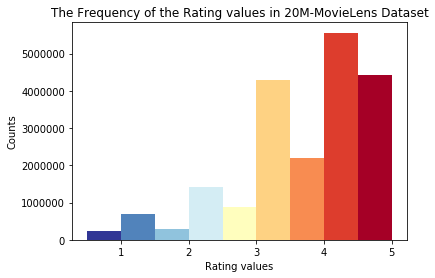

In [65]:
# colormap
cm = plt.cm.get_cmap('RdYlBu_r')
# Plot histogram.
n, bins, patches = plt.hist(ratings_20M, 9, color='green')
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# scale values to interval [0,1]
col = bin_centers - min(bin_centers)
col /= max(col)

for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(c))
    
#plt.hist(ratings, bins = [0.5,1,1.5,2,2.5,3,3.5,4,4.5,5], align='mid')
plt.title("The Frequency of the Rating values in 20M-MovieLens Dataset")
plt.ylabel("Counts")
plt.xlabel("Rating values")
plt.savefig('Frequency_of_rating_values in 20M-MovieLens Dataset.jpg')

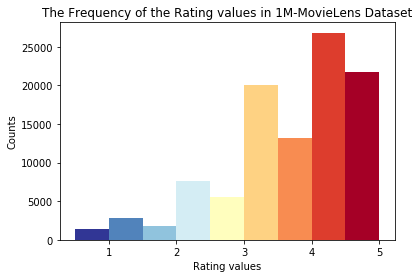

In [66]:
# colormap
cm = plt.cm.get_cmap('RdYlBu_r')
# Plot histogram.
n, bins, patches = plt.hist(ratings, 9, color='green')
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# scale values to interval [0,1]
col = bin_centers - min(bin_centers)
col /= max(col)

for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(c))
    
#plt.hist(ratings, bins = [0.5,1,1.5,2,2.5,3,3.5,4,4.5,5], align='mid')
plt.title("The Frequency of the Rating values in 1M-MovieLens Dataset")
plt.ylabel("Counts")
plt.xlabel("Rating values")
plt.savefig('Frequency_of_rating_values in 1M-MovieLens Dataset.jpg')

The rating distribution from the 20M-MovieLens dataset is similar to that of the 1M-MovieLens dateset. For the collaborative filtering component, will focus on the 1M-MovieLens dataset.

**Comment on the shape of the histogram**: Most of the rating scores gather around 3-5, indicating the users tend to rate movies high in general. This observation suggests us to adjust the threshold for identifying likable movies for my following analysis.

### 3. Distribution of Ratings Among Movies & Among Users

Text(0.5, 0, 'User index')

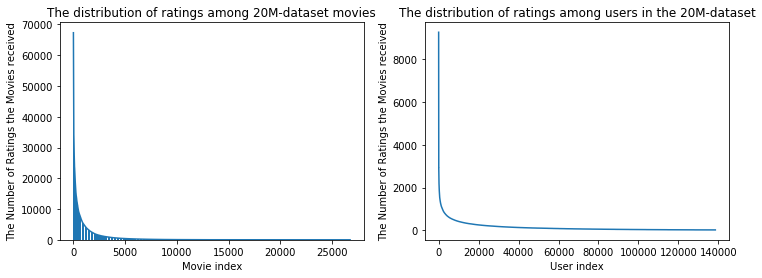

In [68]:
unique_movies_20M, counts_movies_20M = np.unique(movies_20M, return_counts = True)
movie_count_dict_20M = {}
for i in range(len(unique_movies_20M)):
    movie_count_dict_20M[unique_movies_20M [i]] = counts_movies_20M [i]

movie_count_dict_20M = sorted(movie_count_dict_20M.items(), key = lambda item : item[1], reverse = True)


unique_users_20M, counts_users_20M = np.unique(users_20M, return_counts = True)
users_count_dict_20M = {}
for i in range(len(unique_users_20M)):
    users_count_dict_20M[unique_users_20M[i]] = counts_users_20M[i]

users_count_dict_20M = sorted(users_count_dict_20M.items(), key = lambda item : item[1], reverse = True)  

fig_20M, (ax0, ax1) = plt.subplots(1, 2, figsize = (12, 4))

ax0.bar(range(len(movie_count_dict_20M)), [movie_tuple_20M[1] for movie_tuple_20M in movie_count_dict_20M])
ax0.plot(range(len(movie_count_dict_20M)), [movie_tuple_20M[1] for movie_tuple_20M in movie_count_dict_20M])
ax0.set_title('The distribution of ratings among 20M-dataset movies')
ax0.set_ylabel('The Number of Ratings the Movies received')
ax0.set_xlabel('Movie index')

ax1.plot(range(len(users_count_dict_20M)), [users_tuple_20M[1] for users_tuple_20M in users_count_dict_20M])
ax1.set_title('The distribution of ratings among users in the 20M-dataset')
ax1.set_ylabel('The Number of Ratings the Movies received')
ax1.set_xlabel('User index')

Text(0.5, 0, 'User index')

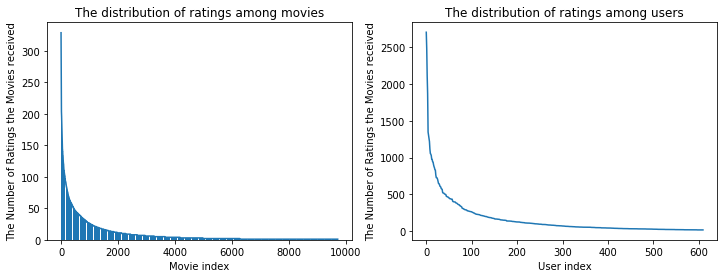

In [67]:
unique_movies, counts_movies = np.unique(movies, return_counts = True)
movie_count_dict = {}
for i in range(len(unique_movies)):
    movie_count_dict[unique_movies [i]] = counts_movies [i]

movie_count_dict = sorted(movie_count_dict.items(), key = lambda item : item[1], reverse = True)


unique_users, counts_users = np.unique(users, return_counts = True)
users_count_dict = {}
for i in range(len(unique_users)):
    users_count_dict[unique_users[i]] = counts_users[i]

users_count_dict = sorted(users_count_dict.items(), key = lambda item : item[1], reverse = True)  

fig, (ax0, ax1) = plt.subplots(1, 2, figsize = (12, 4))

ax0.bar(range(len(movie_count_dict)), [movie_tuple[1] for movie_tuple in movie_count_dict])
ax0.plot(range(len(movie_count_dict)), [movie_tuple[1] for movie_tuple in movie_count_dict])
ax0.set_title('The distribution of ratings among movies')
ax0.set_ylabel('The Number of Ratings the Movies received')
ax0.set_xlabel('Movie index')

ax1.plot(range(len(users_count_dict)), [users_tuple[1] for users_tuple in users_count_dict])
ax1.set_title('The distribution of ratings among users')
ax1.set_ylabel('The Number of Ratings the Movies received')
ax1.set_xlabel('User index')

Not all movies received equal numbers of ratings, with a few movies receiving most of the ratings. This implies that the rating matrix R is very sparse, and training on the sparse matrix will be computationally expensive as well as affect the recommendation accuracy. **More sophisticated techniques for recommendation are required.**

### 4. Variance of the rating values received by each movie

Compute the variance of the rating values received by each movie. Then, bin the variance values into intervals of width 0.5 and use the binned variance values as the horizontal axis. Count the number of movies with variance values in the binned intervals and use this count as the vertical axis.

max variance of the rating score: 5.062500
min variance of the rating score: 0.000000


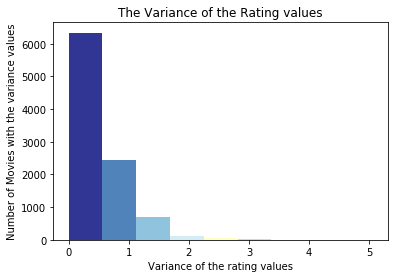

In [69]:
var_movie = []

for i in range(matrix_R.shape[1]):
    rating_values = np.nonzero(matrix_R[:,i]) # nonzero indices in ith column
    var_movie.append(np.var(matrix_R[rating_values,i]))

print("max variance of the rating score: %f" % max(var_movie))
print("min variance of the rating score: %f" % min(var_movie))

# colormap
cm = plt.cm.get_cmap('RdYlBu_r')
# Plot histogram.
n, bins, patches = plt.hist(var_movie, 9, color='green')
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# scale values to interval [0,1]
col = bin_centers - min(bin_centers)
col /= max(col)

for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(c))
    
plt.title("The Variance of the Rating values")
plt.ylabel("Number of Movies with the variance values")
plt.xlabel("Variance of the rating values")
plt.show()

The shape of the histogram follows an exponential shape, and with the variance concentrated mainly in [0,1] interval. This implies that most of the movies receive fairly consistent ratings from users. 

### Neighborhood-based collaborative filtering

The basic idea in neighborhood-based methods is to use either user-user similarity or item-item similarity to make predictions from a ratings matrix. Here are two basic principles used in neighborhood-based methods:
1. User-based models: Similar users have similar ratings on the same item. 
2. Item-based models: Similar items are rated in a similar way by the same user.

This demo implements user-based collaborative filtering (implementation of item-based collaborative filtering is very similar).

### 5. K-NN collaborative filter for rating prediction

Design a k-NN collaborative filter to predict the ratings of the movies in the MovieLens dataset and evaluate it's performance using 10-fold cross validation. Sweep k (number of neighbors) from 2 to 100 in step sizes of 2, and for each k compute the average RMSE and average MAE obtained by averaging RMSE and MAE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis) and average MAE (Y-axis) against k (X-axis).

In [70]:
file_path = 'ratings.csv'

reader = Reader(line_format='user item rating', sep=',', rating_scale=(0.5, 5), skip_lines=1)
data = Dataset.load_from_file(file_path, reader=reader)

sim_options = {'name': 'pearson', 'user_based': True}

rmse = []
mae = []

k = range(2, 102, 2)

for i in k:
    result = cross_validate(KNNWithMeans(k=i, sim_options=sim_options), data, measures=['rmse', 'mae'], cv=10, verbose=False)
    rmse.append(np.mean(result['test_rmse']))
    mae.append(np.mean(result['test_mae']))
    print('\nk = %d\n' %i) 
    print('-' * 80)

# Serializing
with open('RMSE_data', 'wb') as fp:
    pickle.dump(rmse, fp)
with open('MAE_data', 'wb') as fp:
    pickle.dump(mae, fp)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

k = 2

--------------------------------------------------------------------------------
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing simila

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

k = 20

--------------------------------------------------------------------------------
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing simil

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

k = 40

--------------------------------------------------------------------------------
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing simil

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

k = 58

--------------------------------------------------------------------------------
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing simil

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

k = 78

--------------------------------------------------------------------------------
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing simil

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

k = 96

--------------------------------------------------------------------------------
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing simil

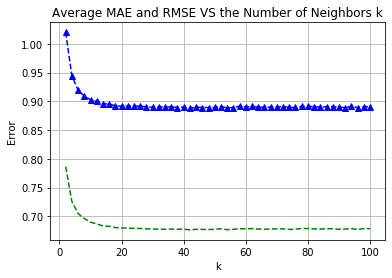

Min RSME: 0.8876909604488912
Min MAE: 0.6762632068226158
42
42


In [71]:
# Deserializing
with open('RMSE_data', 'rb') as fp:
    rmse = pickle.load(fp)
with open('MAE_data', 'rb') as fp:
    mae = pickle.load(fp)

fig, ax = plt.subplots()
ax.plot(k, rmse, 'b--^', k, mae, 'g--')
ax.set(xlabel='k', ylabel='Error',
       title='Average MAE and RMSE VS the Number of Neighbors k')
fig.savefig("Average MAE and RMSE VS the Number of Neighbors k.png")
ax.grid()
plt.show()
min_rmse=min(rmse)
min_mae=min(mae)
print('Min RSME:', min_rmse)
print('Min MAE:', min_mae)
print(k[rmse.index(min_rmse)])
print(k[mae.index(min_mae)])

We define the ‘minimum k’ to be the value that increasing k above this minimum value would not result in a significant decrease in average RMSE or average MAE. It corresponds to the k value for which average RMSE and average MAE converges to a steady-state value and can be used as the most effective k value. 

Found the minimum value for the average RMSE is 0.89 for k = 30, and the minimum value for average MAE is 0.68. also for k = 30. According to the graph, average RMSE and average MAE reach steady states from k = 30. Thus, ‘minimum k’ is found to be 30, and k = 30 is our best choice of k for the number of nearest neighbors.

### Filter Performance on Trimmed Test Set

This part analyzes the performance of the k-NN collaborative filter in predicting the ratings of the movies in the trimmed test set. 
Differet ways of trimming:
1. **Popular Movie Trimming**
2. **Unpopular Movie Trimming**
3. **High variance trimming:** trim the test set to contain movies that have variance (of the rating values received) of at least 2 and has received at least 5 ratings in the entire data set.

In [72]:
file_path = 'ratings.csv'

reader = Reader(line_format='user item rating', sep=',', rating_scale=(0.5, 5), skip_lines=1)
data = Dataset.load_from_file(file_path, reader=reader)
sim_options = {'name': 'pearson', 'user_based': True}

kf = KFold(n_splits=10)
k = range(2, 102, 2)

rates = {} # {movieId:[ratings]}

for row in data.raw_ratings: # row: (userId, movieId, rating, Timestamp)
    # print(row)
    if row[1] not in rates:
        rates[row[1]] = []
    rates[row[1]].append(row[2])

var = {}
for key in rates:
    var[key] = np.var(rates[key])

### 6. K-NN collaborative filter for predicting ratings in the popular movie trimmed test set & evaluate using 10-fold cross validation.

In [73]:
pop_movie = [x for x in rates if len(rates[x]) > 2] #x: movieId (the key of rates)
rmse = []

for i in k:
    algo = KNNWithMeans(k=i, sim_options=sim_options)
    score = []
    for trainset, testset in kf.split(data):
        algo.fit(trainset)
        trimset = [x for x in testset if x[1] in pop_movie] # x[1] is movieId
        predictions = algo.test(trimset)
        score.append(accuracy.rmse(predictions, verbose=True))
    rmse.append(sum(score) / len(score))
    print('\nk = %d, Average RMSE = %.4f\n' % (i, sum(score) / len(score)))
    print('-' * 80)

with open('6_rmse_data', 'wb') as fp:
    pickle.dump(rmse, fp)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0124
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0301
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0133
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0147
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0163
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0005
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9908
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0152
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0036
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0091

k = 2, Average RMSE = 1.0106

---------------------------------------------------------------------

Done computing similarity matrix.
RMSE: 0.8685
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8776
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8698
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8800
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8650
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8861
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8724
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8891
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8749

k = 18, Average RMSE = 0.8760

--------------------------------------------------------------------------------
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8887
Computing the pearson similari

Done computing similarity matrix.
RMSE: 0.8745
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8737
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8845
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8705
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8616
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8713
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8906
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8635

k = 34, Average RMSE = 0.8736

--------------------------------------------------------------------------------
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8700
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8678
Computing the pearson similari

Done computing similarity matrix.
RMSE: 0.8813
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8587
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8661
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8692
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8874
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8745
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8681

k = 50, Average RMSE = 0.8730

--------------------------------------------------------------------------------
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8643
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8881
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8648
Computing the pearson similari

Done computing similarity matrix.
RMSE: 0.8617
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8780
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8725
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8886
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8669
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8763

k = 66, Average RMSE = 0.8737

--------------------------------------------------------------------------------
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8865
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8724
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8736
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8756
Computing the pearson similari

Done computing similarity matrix.
RMSE: 0.8761
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8852
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8733
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8665
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8856

k = 82, Average RMSE = 0.8730

--------------------------------------------------------------------------------
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8704
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8743
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8853
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8773
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8556
Computing the pearson similari

Done computing similarity matrix.
RMSE: 0.8675
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8720
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8801
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8720

k = 98, Average RMSE = 0.8741

--------------------------------------------------------------------------------
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8598
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8829
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8801
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8672
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8709
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8793
Computing the pearson similari

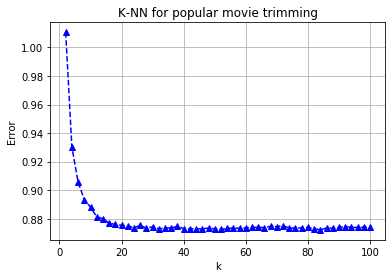

0.8722066375282541
84


In [74]:
with open('6_rmse_data', 'rb') as fp:
    rmse = pickle.load(fp)

fig, ax = plt.subplots()
ax.plot(k, rmse, 'b--^')
ax.set(xlabel='k', ylabel='Error',
       title='K-NN for popular movie trimming')
fig.savefig("K-NN for popular movie trimming.png")
ax.grid()
plt.show()
min_rmse=min(rmse)
print(min_rmse)
print(k[rmse.index(min_rmse)])

### 7. K-NN collaborative filter for predicting ratings in the unpopular movie trimmed test set & evaluate using 10-fold cross validation.

In [75]:
unpop_movie = [x for x in rates if len(rates[x]) <= 2]
rmse = []

for i in k:
    algo = KNNWithMeans(k=i, sim_options=sim_options)
    score = []
    for trainset, testset in kf.split(data):
        algo.fit(trainset)
        trimset = [x for x in testset if x[1] in unpop_movie]
        predictions = algo.test(trimset)
        score.append(accuracy.rmse(predictions, verbose=True))
    rmse.append(sum(score) / len(score))
    print('\nk = %d, Average RMSE = %.4f\n' % (i, sum(score) / len(score)))
    print('-' * 80)  

with open('7_rmse_data', 'wb') as fp:
    pickle.dump(rmse, fp)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0590
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1004
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1204
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0829
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0762
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1411
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1234
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1900
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1285
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1361

k = 2, Average RMSE = 1.1158

---------------------------------------------------------------------

Done computing similarity matrix.
RMSE: 1.0494
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1298
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1379
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1123
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1029
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1015
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1475
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0892
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1633

k = 18, Average RMSE = 1.1193

--------------------------------------------------------------------------------
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1282
Computing the pearson similari

Done computing similarity matrix.
RMSE: 1.0798
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1242
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0726
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1127
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1249
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0712
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1719
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0549

k = 34, Average RMSE = 1.1149

--------------------------------------------------------------------------------
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0823
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1021
Computing the pearson similari

Done computing similarity matrix.
RMSE: 1.1370
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1401
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1436
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0821
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0839
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1835
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0885

k = 50, Average RMSE = 1.1162

--------------------------------------------------------------------------------
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1111
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0628
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1148
Computing the pearson similari

Done computing similarity matrix.
RMSE: 1.1620
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1266
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1775
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0990
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1216
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1317

k = 66, Average RMSE = 1.1200

--------------------------------------------------------------------------------
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1123
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0777
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1668
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1076
Computing the pearson similari

Done computing similarity matrix.
RMSE: 1.0870
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1012
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0726
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1567
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0925

k = 82, Average RMSE = 1.1143

--------------------------------------------------------------------------------
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0776
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0590
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1071
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1799
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0849
Computing the pearson similari

Done computing similarity matrix.
RMSE: 1.0967
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1383
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1340
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1365

k = 98, Average RMSE = 1.1143

--------------------------------------------------------------------------------
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1405
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1516
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1027
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0980
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1452
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1024
Computing the pearson similari

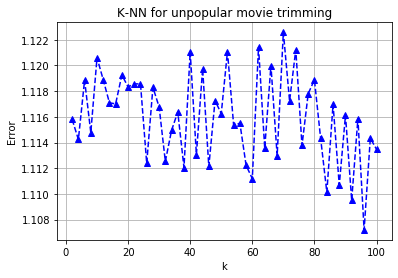

1.1071955280732306
96


In [76]:
with open('7_rmse_data', 'rb') as fp:
    rmse = pickle.load(fp)


fig, ax = plt.subplots()
ax.plot(k, rmse, 'b--^')
ax.set(xlabel='k', ylabel='Error',
       title='K-NN for unpopular movie trimming')
fig.savefig("K-NN for unpopular movie trimming.png")
ax.grid()
plt.show()
min_rmse=min(rmse)
print(min_rmse)
print(k[rmse.index(min_rmse)])

Running it multiple times to show that the best values of k are different each time. However, the minimum average RMSE are roughly the same. One reason for this difference is that the dataset for unpopular movie is too small. The dataset is not large enough to train the model to provide good predictions. Thus, the error and the corresponding minimum k is unstable.

### 8. K-NN collaborative filter for predicting ratings in the high variance movie trimmed test set & evaluate using 10-fold cross validation.

In [77]:
highvar_movie = [x for x in rates if len(rates[x]) >= 5 and var[x] >= 2]
rmse = []

for i in k:
    algo = KNNWithMeans(k=i, sim_options=sim_options)
    score = []
    for trainset, testset in kf.split(data):
        algo.fit(trainset)
        trimset = [x for x in testset if x[1] in highvar_movie]
        predictions = algo.test(trimset)
        score.append(accuracy.rmse(predictions, verbose=True))
    rmse.append(sum(score) / len(score))
    print('\nk = %d, Average RMSE = %.4f\n' % (i, sum(score) / len(score)))
    print('-' * 80)  

with open('8_rmse_data', 'wb') as fp:
    pickle.dump(rmse, fp)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.7973
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5192
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.7991
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.4481
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6390
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.4902
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.9037
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.3594
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.9100
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.4086

k = 2, Average RMSE = 1.6275

---------------------------------------------------------------------

Done computing similarity matrix.
RMSE: 1.7013
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5398
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5053
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.7774
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.7245
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.3152
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5367
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.7152
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6440

k = 18, Average RMSE = 1.5709

--------------------------------------------------------------------------------
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5400
Computing the pearson similari

Done computing similarity matrix.
RMSE: 1.8012
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6001
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.4633
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5088
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5515
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.3968
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.4237
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.7265

k = 34, Average RMSE = 1.5108

--------------------------------------------------------------------------------
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.8437
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6196
Computing the pearson similari

Done computing similarity matrix.
RMSE: 1.5641
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.4360
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.7978
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0840
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5155
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6521
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6760

k = 50, Average RMSE = 1.5456

--------------------------------------------------------------------------------
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1617
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5033
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.8154
Computing the pearson similari

Done computing similarity matrix.
RMSE: 1.6497
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9013
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.7732
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 2.2215
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6864
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.4953

k = 66, Average RMSE = 1.5403

--------------------------------------------------------------------------------
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.4555
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1495
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5138
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.7012
Computing the pearson similari

Done computing similarity matrix.
RMSE: 1.7588
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.3906
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6840
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 2.1094
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.4533

k = 82, Average RMSE = 1.5495

--------------------------------------------------------------------------------
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.7564
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.4761
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.3548
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5129
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6593
Computing the pearson similari

Done computing similarity matrix.
RMSE: 1.5567
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.3706
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.3621
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.8116

k = 98, Average RMSE = 1.5226

--------------------------------------------------------------------------------
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.4382
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6561
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6813
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.4453
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 2.1558
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.4183
Computing the pearson similari

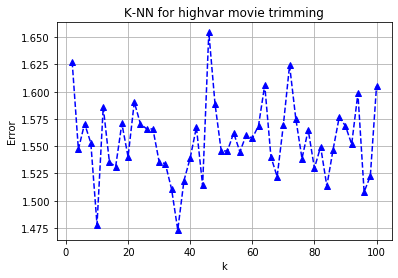

1.4732281377896443
36


In [78]:
with open('8_rmse_data', 'rb') as fp:
    rmse = pickle.load(fp)

fig, ax = plt.subplots()
ax.plot(k, rmse, 'b--^')
ax.set(xlabel='k', ylabel='Error',
       title='K-NN for highvar movie trimming')
ax.grid()
plt.show()
min_rmse=min(rmse)
print(min_rmse)
print(k[rmse.index(min_rmse)])

### Performance evalutation using ROC curve for the recommendation system

- Use receiver operating characteristics curve to visualize performance of binary classifier.

- In the contect of recommendation systems, ROC measures the relevance of the items recommended to the user. 

- Convert ratings to a binary scale by thresholding.

### 9. Plot the ROC curves for the k-NN collaborative filter designed for threshold values [2.5, 3, 3.5, 4].  

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.


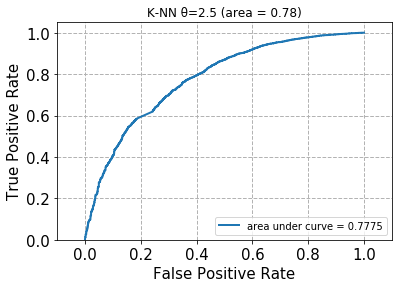

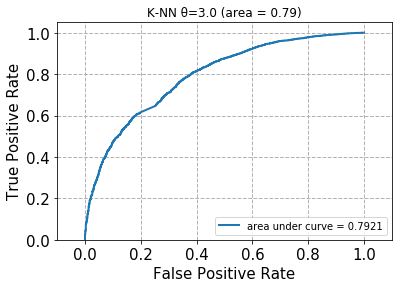

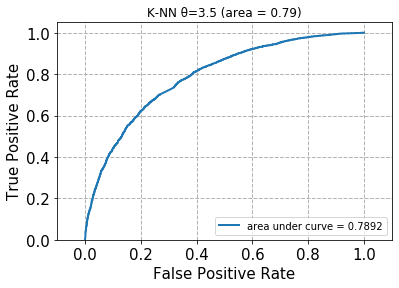

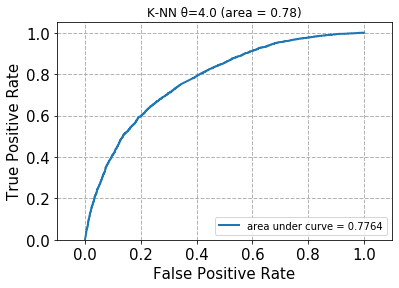

In [79]:
def plot_roc(fpr, tpr, name):
    fig, ax = plt.subplots()
    roc_auc = metrics.auc(fpr,tpr)

    ax.plot(fpr, tpr, lw=2, label= 'area under curve = %0.4f' % roc_auc)
    ax.grid(color='0.7', linestyle='--', linewidth=1)
    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=15)
    ax.set_ylabel('True Positive Rate',fontsize=15)
    ax.set_title(name)
    ax.legend(loc="lower right")

    for label in ax.get_xticklabels()+ax.get_yticklabels():
        label.set_fontsize(15)


k_best = 30
threshold = [2.5, 3, 3.5, 4]

def threshold_plot(algo):
    for theta in threshold:

        df = rating_data

        reader = Reader(rating_scale=(0.5, 5))
        data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

        trainset, testset = train_test_split(data, test_size=.1)

        algo.fit(trainset)
        predictions = algo.test(testset) #predictions: (uid, iid, r_ui, est, details)

        trues = [0 if getattr(row, 'r_ui') < theta else 1 for row in predictions]
        scores = [getattr(row, 'est') for row in predictions]
        fpr, tpr, thresholds = metrics.roc_curve(trues, scores)
        roc_auc = metrics.auc(fpr, tpr)

        name = 'K-NN θ=%.1f (area = %0.2f)' % (theta, roc_auc)
        plot_roc(fpr,tpr,name)

        
algo = KNNWithMeans(k=k_best, sim_options=sim_options)
threshold_plot(algo)

The aim for a recommendation system is to maximize the area under the ROC curve. The area under the curve (AUC) can therefore be used as a measure for the overall quality of a recommender system. The highest AUC is found with the threshold value equals to 3.

- A perfect recommender would yield a ROC curve that goes straight up towards 1.0 recall and 0.0 fallout until all relevant items are retrieved. Afterwards it would go straight right towards 1.0 fallout while the remaining irrelevant items follow.


### Model-based (Latent factor) collaborative filtering

Models are developed using ML algorithms to predict users' rating of unrated items.
Model-based methods:
- decision tree
- rule-based models
- bayesian methods
- **latent factor based models**

The matrix factorization problem in latent factor based model can be formulated as an optimization problem and could be solved by the optimization problem using:

$\displaystyle \underset{U,V}{  \text{minimize} }  \,\,\sum_{i=1}^m \sum_{j=1}^n W_{i,j}(r_{i,j}-(UV^T)_{i,j})^2+\lambda \|U\|_F^2 + \lambda \|V\|_F^2 $

$W_{i,j} = \begin{cases}
1, & \, r_{i,j} \,\text{is known}\\
0, & \, r_{i,j} \,\text{is unknown}\\
\end{cases}$

Decompose $R$ into $UV^T$, where $U$ and $V$ are latent.

#### Non-negative matrix factorization ($U$, $V$ >=0)

### 10. NNMF-based collaborative filter for rating predictions

Sweep k(number of latent factors) from 2 to 50 in step sizes
of 2, and for each k compute the average RMSE and average MAE obtained by averaging the RMSE and MAE across all 10 folds. 

In [80]:
k = range(2, 52, 2) # Number of latent factors
rmse = []
mae = []

for i in k:
    result = cross_validate(NMF(n_factors=i, biased=False), data, measures=['rmse', 'mae'], cv=10, verbose=False)
    rmse.append(np.mean(result['test_rmse']))
    mae.append(np.mean(result['test_mae']))
    print('\nk = %d\n' %i) 
    print('-' * 80)

with open('10_rmse_data', 'wb') as fp:
    pickle.dump(rmse, fp)
with open('10_mae_data', 'wb') as fp:
    pickle.dump(mae, fp)


k = 2

--------------------------------------------------------------------------------

k = 4

--------------------------------------------------------------------------------

k = 6

--------------------------------------------------------------------------------

k = 8

--------------------------------------------------------------------------------

k = 10

--------------------------------------------------------------------------------

k = 12

--------------------------------------------------------------------------------

k = 14

--------------------------------------------------------------------------------

k = 16

--------------------------------------------------------------------------------

k = 18

--------------------------------------------------------------------------------

k = 20

--------------------------------------------------------------------------------

k = 22

--------------------------------------------------------------------------------

k = 24

-----

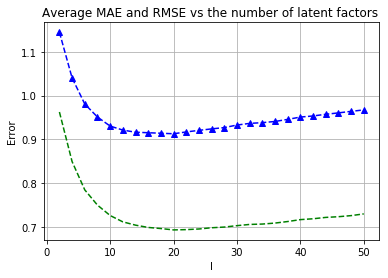

0.9125764911700965
0.6926906871254553
20
20


In [81]:
with open('10_rmse_data', 'rb') as fp:
    rmse = pickle.load(fp)
with open('10_mae_data', 'rb') as fp:
    mae = pickle.load(fp)

fig, ax = plt.subplots()
ax.plot(k, rmse, 'b--^', k, mae, 'g--')
ax.set(xlabel='l', ylabel='Error',
       title='Average MAE and RMSE vs the number of latent factors ')
ax.grid()
plt.show()
min_rmse=min(rmse)
min_mae=min(mae)
print(min_rmse)
print(min_mae)
print(k[rmse.index(min_rmse)])
print(k[mae.index(min_mae)])

Optimal number of latent factors (k = 18). The number of genres is 18, which is the same as the number of latent factors. 

Next, design a NNMF collaborative filter to predict the ratings of the movies in the popular movie trimmed test set, unpopular movie trimmed test set and high variance movie trimmed test set, respectively. Evaluate the filter performance with different trimmed test sets using 10-fold cross validation.

### 11. NNMF collaborative filter for predict popular movie ratings

In [82]:
kf = KFold(n_splits=10)

rmse = []

for i in k:
    algo = NMF(n_factors=i, biased=False)
    score = []
    for trainset, testset in kf.split(data):
        algo.fit(trainset)
        trimset = [x for x in testset if x[1] in pop_movie] #x[1] is movieId
        predictions = algo.test(trimset)
        score.append(accuracy.rmse(predictions, verbose=True))
    rmse.append(sum(score) / len(score))
    print('\nk = %d, Average RMSE = %.4f\n' % (i, sum(score) / len(score)))
    print('-' * 80)

with open('11_rmse_data', 'wb') as fp:
    pickle.dump(rmse, fp)

RMSE: 1.1444
RMSE: 1.1325
RMSE: 1.1344
RMSE: 1.1344
RMSE: 1.1488
RMSE: 1.1358
RMSE: 1.1395
RMSE: 1.1492
RMSE: 1.1463
RMSE: 1.1277

k = 2, Average RMSE = 1.1393

--------------------------------------------------------------------------------
RMSE: 1.0285
RMSE: 1.0242
RMSE: 1.0243
RMSE: 1.0230
RMSE: 1.0392
RMSE: 1.0234
RMSE: 1.0244
RMSE: 1.0236
RMSE: 1.0211
RMSE: 1.0185

k = 4, Average RMSE = 1.0250

--------------------------------------------------------------------------------
RMSE: 0.9556
RMSE: 0.9697
RMSE: 0.9788
RMSE: 0.9613
RMSE: 0.9730
RMSE: 0.9658
RMSE: 0.9690
RMSE: 0.9591
RMSE: 0.9674
RMSE: 0.9738

k = 6, Average RMSE = 0.9673

--------------------------------------------------------------------------------
RMSE: 0.9409
RMSE: 0.9299
RMSE: 0.9323
RMSE: 0.9192
RMSE: 0.9380
RMSE: 0.9261
RMSE: 0.9265
RMSE: 0.9244
RMSE: 0.9381
RMSE: 0.9359

k = 8, Average RMSE = 0.9311

--------------------------------------------------------------------------------
RMSE: 0.9123
RMSE: 0.9069
RMSE: 

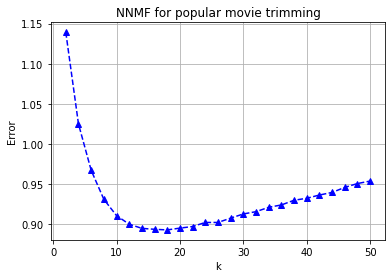

0.893017975684476
18


In [83]:
with open('11_rmse_data', 'rb') as fp:
    rmse = pickle.load(fp)
k = range(2, 52, 2)
fig, ax = plt.subplots()
ax.plot(k, rmse, 'b--^')
ax.set(xlabel='k', ylabel='Error',
       title='NNMF for popular movie trimming')
fig.savefig("11 NNMF for popular movie trimming.png")
ax.grid()
plt.show()
min_rmse=min(rmse)
print(min_rmse)
print(k[rmse.index(min_rmse)])

### 12. NNMF collaborative filter to predict popular movie ratings

In [84]:
rmse = []

for i in k:
    algo = NMF(n_factors=i, biased=False)
    score = []
    for trainset, testset in kf.split(data):
        algo.fit(trainset)
        trimset = [x for x in testset if x[1] in unpop_movie] #x[1] is movieId
        predictions = algo.test(trimset)
        score.append(accuracy.rmse(predictions, verbose=True))
    rmse.append(sum(score) / len(score))
    print('\nk = %d, Average RMSE = %.4f\n' % (i, sum(score) / len(score)))
    print('-' * 80)
           
with open('12_rmse_data', 'wb') as fp:
    pickle.dump(rmse, fp)

RMSE: 1.2493
RMSE: 1.2065
RMSE: 1.2634
RMSE: 1.2286
RMSE: 1.2320
RMSE: 1.2261
RMSE: 1.2199
RMSE: 1.1902
RMSE: 1.3068
RMSE: 1.2014

k = 2, Average RMSE = 1.2324

--------------------------------------------------------------------------------
RMSE: 1.2158
RMSE: 1.1911
RMSE: 1.2058
RMSE: 1.1933
RMSE: 1.2879
RMSE: 1.2267
RMSE: 1.2539
RMSE: 1.2625
RMSE: 1.2175
RMSE: 1.2192

k = 4, Average RMSE = 1.2274

--------------------------------------------------------------------------------
RMSE: 1.2048
RMSE: 1.1718
RMSE: 1.2556
RMSE: 1.2401
RMSE: 1.1912
RMSE: 1.2601
RMSE: 1.1487
RMSE: 1.2175
RMSE: 1.2383
RMSE: 1.2311

k = 6, Average RMSE = 1.2159

--------------------------------------------------------------------------------
RMSE: 1.2310
RMSE: 1.1095
RMSE: 1.2479
RMSE: 1.1791
RMSE: 1.2579
RMSE: 1.1563
RMSE: 1.2523
RMSE: 1.1963
RMSE: 1.2596
RMSE: 1.2336

k = 8, Average RMSE = 1.2123

--------------------------------------------------------------------------------
RMSE: 1.2134
RMSE: 1.2211
RMSE: 

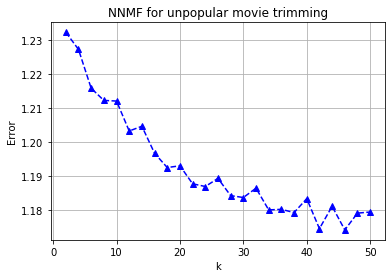

1.1741975099509931
46


In [85]:
with open('12_rmse_data', 'rb') as fp:
    rmse = pickle.load(fp)
    
fig, ax = plt.subplots()
ax.plot(k, rmse, 'b--^')
ax.set(xlabel='k', ylabel='Error',
       title='NNMF for unpopular movie trimming')
fig.savefig("12 NNMF for unpopular movie trimming.png")
ax.grid()
plt.show()
min_rmse=min(rmse)
print(min_rmse)
print(k[rmse.index(min_rmse)])

### 13. NNMF collaborative filter to predict unpopular movie ratings

In [86]:
rmse = []
for i in k:
    algo = NMF(n_factors=i, biased=False)
    score = []
    for trainset, testset in kf.split(data):
        algo.fit(trainset)
        trimset = [x for x in testset if x[1] in highvar_movie] #x[1] is movieId
        predictions = algo.test(trimset)
        score.append(accuracy.rmse(predictions, verbose=True))
    rmse.append(sum(score) / len(score))
    print('\nk = %d, Average RMSE = %.4f\n' % (i, sum(score) / len(score)))
    print('-' * 80) 

with open('13_rmse_data', 'wb') as fp:
    pickle.dump(rmse, fp)

RMSE: 1.6237
RMSE: 1.8663
RMSE: 1.8579
RMSE: 1.8158
RMSE: 1.6464
RMSE: 1.4424
RMSE: 1.7295
RMSE: 1.4724
RMSE: 1.8249
RMSE: 1.6733

k = 2, Average RMSE = 1.6952

--------------------------------------------------------------------------------
RMSE: 1.7821
RMSE: 1.6458
RMSE: 1.2506
RMSE: 1.4373
RMSE: 2.1634
RMSE: 1.6283
RMSE: 1.3612
RMSE: 1.5936
RMSE: 1.8051
RMSE: 1.7902

k = 4, Average RMSE = 1.6458

--------------------------------------------------------------------------------
RMSE: 2.0383
RMSE: 1.4806
RMSE: 1.5029
RMSE: 1.5577
RMSE: 2.0468
RMSE: 1.6810
RMSE: 1.6538
RMSE: 1.7909
RMSE: 1.6810
RMSE: 1.6653

k = 6, Average RMSE = 1.7098

--------------------------------------------------------------------------------
RMSE: 1.6688
RMSE: 1.5584
RMSE: 1.5363
RMSE: 1.6090
RMSE: 1.7190
RMSE: 1.5642
RMSE: 1.7687
RMSE: 1.9862
RMSE: 1.8179
RMSE: 2.0847

k = 8, Average RMSE = 1.7313

--------------------------------------------------------------------------------
RMSE: 1.5048
RMSE: 1.5847
RMSE: 

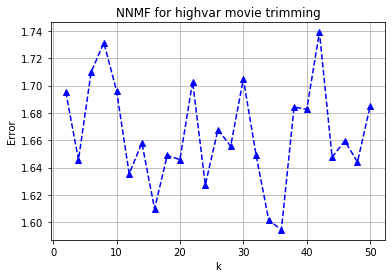

1.5944323436985612
36


In [87]:
with open('13_rmse_data', 'rb') as fp:
    rmse = pickle.load(fp)
    
fig, ax = plt.subplots()
ax.plot(k, rmse, 'b--^')
ax.set(xlabel='k', ylabel='Error',
       title='NNMF for highvar movie trimming')
fig.savefig("Q21 NNMF for highvar movie trimming.png")
ax.grid()
plt.show()
min_rmse=min(rmse)
print(min_rmse)
print(k[rmse.index(min_rmse)])

### Performance evalutation using ROC curve for NNMF-based filter

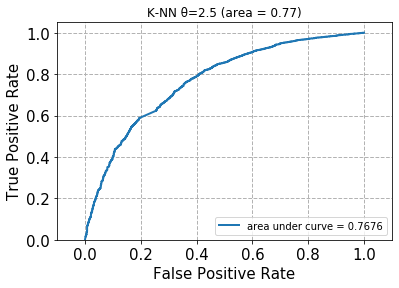

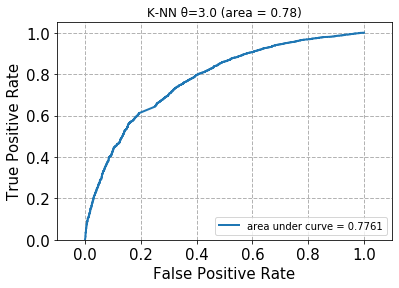

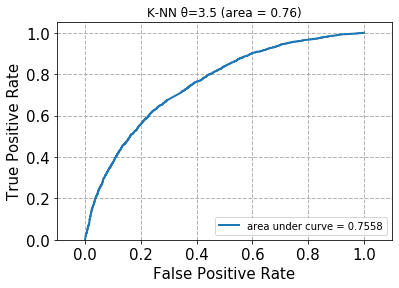

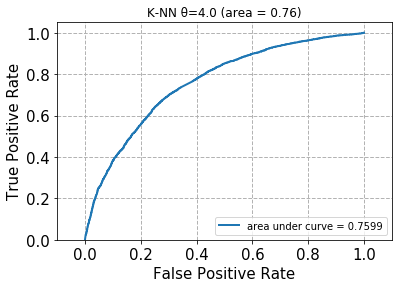

In [88]:
n_factors_best = 18
algo = NMF(n_factors=n_factors_best, biased=False)
threshold_plot(algo)

### Interpretability of NNMF

The major advantage of NNMF over other forms of matrix factorization is the high level of interpretability it provides in understanding user-item interactions. 

In the next part, the interpretability of NNMF is explored. Specifically, the connection between the latent factors and the movie genres.

### 14. NNMF on the ratings matrix R to obtain factor matrices U and V

Perform NNMF on the ratings matrix R to obtain the factor matrices U and V, where U represents the user-latent factors interaction and V represents the movie-latent factors interaction (k = 20). For each column of V, sort the movies in descending order and report the genres of the top 10 movies. 

In [89]:
trainset = data.build_full_trainset()
model = NMF(n_factors=20, n_epochs=20, biased=False)
model.fit(trainset)
U = model.pu
V = model.qi
# print(U.shape)
# print(V.shape)

all_movies = pd.read_csv('ml-latest-small/movies.csv') 
all_moviesId = all_movies['movieId'] #unique, no duplicates
all_moviesId_map_index = {} #the mapping in movies.csv: key is actual movie id, value is index id(0,1,2...)

for i in range(len(all_moviesId)):
    all_moviesId_map_index[list(all_moviesId)[i]] = i

columns20 = []
for i in range(20): #column i of V
    column = V[:,i]
    sorted_column = -np.sort(-column) #desc
    #print(sorted_column)
    movie_ids = [0]*10 #store top 10 movie index ids in column j
    movie_genres = []
    for j in range(10):
        movie_ids[j] = list(column).index(sorted_column[j]) 
        for m_id, index in movieId_map_col.items(): #get key(movie_id) from value(index_id)
            if index == movie_ids[j]:
                actual_movie_id = m_id
                mapped_id = all_moviesId_map_index[actual_movie_id]
        movie_genres.append(all_movies['genres'][mapped_id])
    columns20.append(movie_genres)
    
for column_i in columns20:
    for k in range(10):
        print(column_i[k])
    print('\n')

Drama
Drama
Action|Drama|Thriller
Comedy
Action|Adventure
Horror
Adventure|Animation|Fantasy|Sci-Fi
Comedy
Adventure|Sci-Fi
Horror|Thriller


Action|Adventure|Fantasy
Action|Adventure|Fantasy
Comedy|Musical|Romance
Comedy|Fantasy|Romance
Documentary
Drama|Horror|Mystery|Thriller
Action|Adventure|Drama|War
Comedy
Comedy|Romance
Action|Adventure|Drama|Fantasy|Romance|Sci-Fi|Thriller


Crime|Drama|Thriller
Comedy|Crime
Crime|Thriller
Comedy|Drama|Romance
Documentary|Horror
Adventure|Animation|Children|Comedy|Fantasy
Thriller
Documentary
Action|Comedy|Sci-Fi
Action|Adventure|Fantasy


Comedy
Crime|Drama|Mystery|Thriller
Adventure
Drama
Drama|Romance
Drama|Romance
Drama|Thriller
Horror|Thriller
Drama
Drama


Crime|Drama|Thriller
Drama|War
Drama
Drama|Romance
Comedy|Musical
Children|Musical
Action|Animation|Sci-Fi
Action|Crime|Drama|Thriller
Crime|Thriller
Comedy|Romance


Comedy
Comedy|Horror
Crime|Drama|Thriller
Comedy|Horror|Mystery|Thriller
Action|Drama|Romance
Horror|Mystery|Thriller
Ac

The top 10 movies belong to a particular or a small collection of genre. The number of latent factors is related to the number of movie genres.

## 2. Multi-Class Classifier for images

### 2A. Logistic Regression

Minimize the objective function with L1-reguarization:

$$ \displaystyle  J(\boldsymbol{W} ) = \frac{1}{N} \left[ \sum_{i=1}^n \log\left(\sum_{j=1}^k e^{w_j^{\top} x_i } \right) -  \sum_{i=1}^N w_{y_i}^{\top} x_i  \right] +  \lambda \sum_{j=1}^k \sum_{l=1}^{d} \vert w_{jl}\vert $$

In [40]:
class Logistic(object):
    def __init__(self, dim=[10,784], reg_param=0):
        """"
        Inputs:
          - dim: dimensions of the weights [number_classes X number_features]
          - reg : Regularization type [L2,L1,L]
          - regularization parameter reg_param
        Goal:
         - Initialize the weight vector self.w
         - Initialize the  regularization parameter self.reg
        """
        self.reg  = reg_param
        dim[1] += 1
        self.dim = dim
        self.w = np.zeros(self.dim)
        
    def gen_features(self, X):
        """
        Inputs:
         - X: A numpy array of shape (N,d) containing the data.
        Returns:
         - X_out an augmented training data to a feature vector e.g. [1, X].
        """
        N,d = X.shape
        X_out= np.zeros((N,d+1))
        X_out = np.hstack((np.ones((N,1)), X))
        return X_out  
        
    def loss_and_grad(self, X, y):
        """
        Inputs:
        - X: N x d array of training data.
        - y: N x 1 labels 
        Returns:
        - loss: a real number represents the loss 
        - grad: a vector of the same dimensions as self.w containing the gradient of the loss with respect to self.w 
        """
        loss = 0.0
        grad = np.zeros_like(self.w) 
        N, d = X.shape
        X = self.gen_features(X)
        k = len(self.w) # row number
    
        for i in range(N):
            sum_k = 0.0
            grad_sum_k = np.zeros_like(self.w) #(k = 1, d + 1 = 786)
            for j in range(self.dim[0]): 
                sum_k += np.exp(np.dot(self.w[j].T, X[i]))
                grad_sum_k[j] += np.exp(np.dot(self.w[j].T, X[i]))*X[i]
            index = int(y[i])
            loss += 1/N*(np.log(sum_k)-np.dot(self.w[index].T, X[i]))
            grad += 1/N*(grad_sum_k)/sum_k
            grad[index] -= X[i]/N
        # print("grad_sum_k.shape:",grad_sum_k.shape, grad.shape)
        # print(grad_sum_k[1])
        loss += self.reg*np.sum(abs(self.w))
        grad += self.reg*np.sign(self.w)
        return loss, grad
    
    def train_LR(self, X, y, eta=1e-3, batch_size=1, num_iters=1000) :
        """
        Inputs:
         - X         -- numpy array of shape (N,d), features
         - y         -- numpy array of shape (N,), labels
         - eta       -- float, learning rate
         - num_iters -- integer, maximum number of iterations
        Returns:
         - loss_history: vector containing the loss at each training iteration.
         - self.w: optimal weights 
        """
        loss_history = []
        N,d = X.shape
        for t in np.arange(num_iters):
                X_batch = None
                y_batch = None
                indices = np.random.choice(np.arange(N), batch_size)
                X_batch, y_batch = X[indices,:], y[indices]
                loss = 0.0
                grad = np.zeros_like(self.w)
                loss, grad = self.loss_and_grad(X_batch, y_batch)
                self.w = self.w - eta*grad
                loss_history.append(loss)
        return loss_history, self.w
    
    def predict(self, X):
        """
        Inputs:
        - X: N x d array of training data.
        Returns:
        - y_pred: Predicted labelss for the data in X. y_pred is a 1-dimensional
          array of length N.
        """
        y_pred = np.zeros(X.shape[0])
        X_out = self.gen_features(X)
        N = X.shape[0]
        for i in range(N):
            max_value = 0.0
            max_label = 0
            for j in range(self.dim[0]):
                exp = np.exp(np.dot(self.w[j].T, X_out[i]))
                if exp > max_value:
                    max_value = exp
                    max_label = j
            y_pred[i] = max_label
        return y_pred

In [41]:
%load_ext autoreload
%autoreload 2
from data_load import load_mnist
import random
import csv
import scipy.io as io

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
X_train,X_test,y_train,y_test=load_mnist()

print('Train data shape: ', X_train.shape)
print('Train target shape: ', y_train.shape)
print('Test data shape: ',X_test.shape)
print('Test target shape: ',y_test.shape)

Train data shape:  (60000, 784)
Train target shape:  (60000,)
Test data shape:  (10000, 784)
Test target shape:  (10000,)


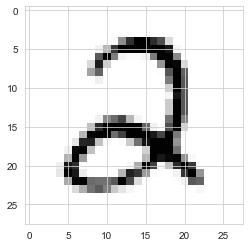

label is 2


In [80]:
# To Visualize a point in the dataset
index = 7484
X = np.array(X_train[index], dtype='uint8')
X = X.reshape((28, 28))
fig = plt.figure()
plt.imshow(X, cmap='Greys')
plt.show()
fig.savefig('Sample.pdf')
print('label is', y_train[index])

#### Train Multi-Class Logistic Regression

In [44]:
num_classes = len(np.unique(y_train))
num_features = X_train.shape[1]

logistic = Logistic(dim=[num_classes,num_features], reg_param=0)
loss, grad = logistic.loss_and_grad(X_train[:5000],y_train[:5000])
print('Loss function=',loss)
print('Frobenius norm of grad=',np.linalg.norm(grad))

Loss function= 2.3025850929939784
Frobenius norm of grad= 269.57149388566296


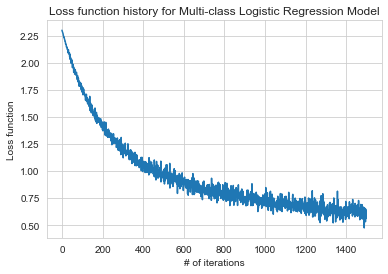

Frobenius norm: 0.013281559515176606
Final value of loss function: 0.6279413898970582


In [45]:
loss_history, w = logistic.train_LR(X_train,y_train, eta=1e-7,batch_size=200, num_iters=1500)
fig = plt.figure()
plt.plot(loss_history)
plt.title('Loss function history for Multi-class Logistic Regression Model')
plt.xlabel('# of iterations')
plt.ylabel('Loss function')
plt.show()
print('Frobenius norm:', np.linalg.norm(w))
print('Final value of loss function:',loss_history[1499])

#### Compute training & test error

In [46]:
def error(X, y):
    y_pred = logistic.predict(X)
    count = 0
    for i in range(len(y_pred)): 
        if y_pred[i] != y[i]:
            count += 1
        error = count/len(y_pred)
    return error
    # print('error:',error,'%')

train_error = error(X_train, y_train)
print('Training Error:', train_error*100, '%')

test_error = error(X_test, y_test)
print('Testing Error:', test_error*100, '%')

Training Error: 14.030000000000001 %
Testing Error: 12.98 %


In [47]:
reg = [0,1e-6,1e-5, 1e-4, 1e-3,5e-2,1e-2,5e-1,1e-1,1]
train_err =[]
test_err =[]
for r in reg:
    logistic = Logistic(dim=[num_classes,num_features], reg_param=r)
    loss_history, w = logistic.train_LR(X_train,y_train, eta=1e-7, batch_size=200, num_iters=3000)
    train_err.append(error(X_train,y_train))
    test_err.append(error(X_test,y_test))    

In [48]:
print('Training error with different regularizations:', train_err)
print('Testing error with different regularizations:',test_err)

Training error with different regularizations: [0.12471666666666667, 0.12488333333333333, 0.124, 0.12466666666666666, 0.12498333333333334, 0.12505, 0.12481666666666667, 0.1363, 0.12675, 0.1471]
Testing error with different regularizations: [0.1164, 0.1157, 0.1168, 0.117, 0.116, 0.1169, 0.1162, 0.1276, 0.1177, 0.1394]


Text(0, 0.5, 'Error')

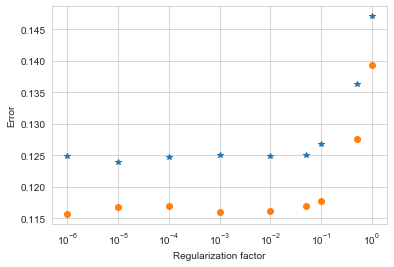

In [49]:
plt.xscale('log')
plt.plot(reg, train_err, '*', label='training error')
plt.plot(reg, test_err, 'o', label='testing error')
plt.xlabel('Regularization factor')
plt.ylabel('Error')

### 2B. Decision Tree Classifier & Adaboost

In [50]:
from sklearn.tree import DecisionTreeClassifier

Text(0, 0.5, 'Error')

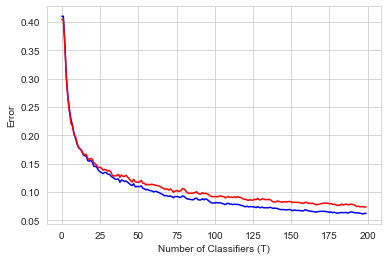

In [51]:
T = 200
N = X_train.shape[0]
num_classes = len(np.unique(y_train))
num_features = X_train.shape[1]
train_err = np.zeros((T,1))
test_err = np.zeros((T,1))

#Initialize
alpha = np.ones(T)
# sample weights D = [d1, d2, ..., dN], di = 1/N
D = np.ones(N)/N
train_matrix = np.zeros((N, num_classes))
test_matrix = np.zeros((X_test.shape[0], num_classes))

for m in range(0,T):
    # Train decision Tree
    tree = DecisionTreeClassifier(max_depth = 4).fit(X_train, y_train, sample_weight = D)
    # Compute error
    error = 1 - tree.score(X_train, y_train, sample_weight = D)
    # Compute \alpha
    alpha[m] = np.log((1-error)/error) + np.log(num_classes - 1)
    # Update weights
    y_pred_train = tree.predict(X_train)
    y_pred_test = tree.predict(X_test)
    for i in range(N):
        if y_pred_train[i]!=y_train[i]:
            D[i] *= np.exp(alpha[m])
    # Normalize the sample weights
    D = D/np.sum(D)
    # Predict using Last t classifiers
    # Construct a matrix row # feature x, column, predicted label
    for i in range(N):
        train_matrix[i][y_pred_train[i]] += alpha[m]
    for j in range(X_test.shape[0]):
        test_matrix[j][y_pred_test[j]] += alpha[m]
    # Compute test error and train error
    trainError = 0
    testError = 0
    for i in range(N):
        index_train = np.argmax(train_matrix[i])
        if index_train != y_train[i]:
            trainError += 1
    for i in range(X_test.shape[0]):
        index_test = np.argmax(test_matrix[i])
        if index_test != y_test[i]:
            testError += 1
    train_err[m]=trainError/N
    test_err[m]=testError/X_test.shape[0]
    
# Plot test error and train error in the same plot vs T
plt.plot(train_err, "-b", label='training error')
plt.plot(test_err, "-r", label='testing error')
plt.xlabel("Number of Classifiers (T)")
plt.ylabel("Error")

In [52]:
#Test error for T = 1 and Test error for T = 200
print('Test error for T = 1', test_err[0])
print('Test error for T = 200', test_err[-1])

Test error for T = 1 [0.4043]
Test error for T = 200 [0.0736]


### 2C. Using deep learning for classifying the images

In [20]:
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 1s 0us/step


6


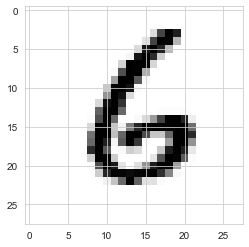

In [53]:
import matplotlib.pyplot as plt
image_index = 6000 
print(y_train[image_index]) 
plt.imshow(x_train[image_index], cmap='Greys')

In [54]:
x_train.shape

(60000, 28, 28)

In [55]:
# Reshaping the array to 4-dims for Keras API
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Normalizing the images
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print('Number of images in x_train', x_train.shape[0])
print('Number of images in x_test', x_test.shape[0])

x_train shape: (60000, 28, 28, 1)
Number of images in x_train 60000
Number of images in x_test 10000


### Convolutional Neural Network construction

In [61]:
# Importing the required Keras modules containing model and layers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

# Creating a Sequential Model and adding the layers
model = Sequential()
# Feature Extraction
model.add(Conv2D(28, kernel_size=(3,3), input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten()) # Flattening the 2D arrays for fully connected layers
model.add(Dense(128, activation=tf.nn.relu))
model.add(Dropout(0.3))
model.add(Dense(10,activation=tf.nn.softmax)) # 10 number of classes

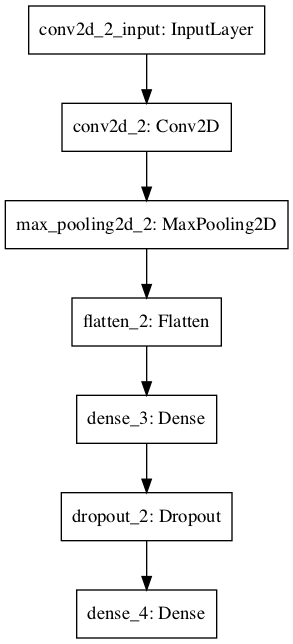

In [63]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96)

In [64]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
model.fit(x=x_train,y=y_train, epochs=30)

Epoch 1/30
60000/60000 [==============================] - 14s 228us/step - loss: 0.2438 - accuracy: 0.9255
Epoch 2/30
60000/60000 [==============================] - 14s 236us/step - loss: 0.1007 - accuracy: 0.9687
Epoch 3/30
60000/60000 [==============================] - 13s 224us/step - loss: 0.0743 - accuracy: 0.9772
Epoch 4/30
60000/60000 [==============================] - 14s 227us/step - loss: 0.0589 - accuracy: 0.9808
Epoch 5/30
60000/60000 [==============================] - 14s 236us/step - loss: 0.0496 - accuracy: 0.9844
Epoch 6/30
60000/60000 [==============================] - 14s 240us/step - loss: 0.0393 - accuracy: 0.9870
Epoch 7/30
60000/60000 [==============================] - 14s 230us/step - loss: 0.0349 - accuracy: 0.9884
Epoch 8/30
60000/60000 [==============================] - 14s 227us/step - loss: 0.0297 - accuracy: 0.9899
Epoch 9/30
60000/60000 [==============================] - 14s 230us/step - loss: 0.0297 - accuracy: 0.9904
Epoch 10/30
60000/60000 [============

#### Model Evaluation

In [65]:
model.evaluate(x_test, y_test)

10000/10000 [==============================] - 0s 42us/step


[0.08743303847210879, 0.9860000014305115]

#### Prediction result example 

9


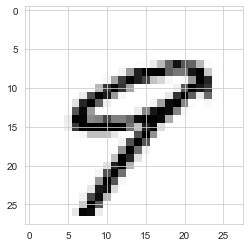

In [75]:
image_index = 6650
plt.imshow(x_test[image_index].reshape(28, 28),cmap='Greys')
pred = model.predict(x_test[image_index].reshape(1, 28, 28, 1))
print(pred.argmax())

## 3. Sparse coding & K-SVD on Data Incubator Photo for text removal

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc
from scipy import signal

import imageio
from skimage import io, color, util
from skimage.metrics import peak_signal_noise_ratio, structural_similarity as ssim

from sklearn.feature_extraction.image import extract_patches_2d
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.preprocessing import normalize
from sklearn.linear_model import orthogonal_mp

import cv2 as cv
import copy

In [19]:
# Normalize any matrix to the range of [0, 1]
def norm(x):
    x = np.array(x)
    x_min = np.min(x)
    x_max = np.max(x)
    x = (x - x_min)/(x_max - x_min)
    return x

In [20]:
image1 = io.imread('dataincubator_test.png')
image2 = io.imread('dataincubator_image_train.png')

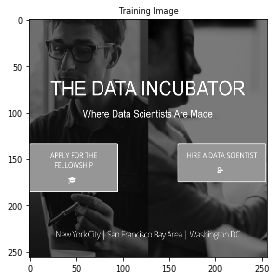

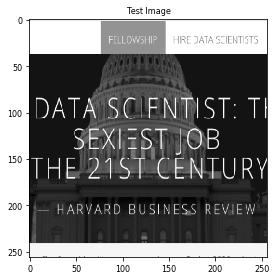

In [21]:
image1 = cv.resize(image1, (256, 256))
y_train = color.rgb2gray(image1)
y_train = norm(y_train)

image2 = image2[:, 0: 2117, :]
image2 = cv.resize(image2, (256, 256))
y_test = color.rgb2gray(image2)
y_test = norm(y_test)

# plot y_train
fig, ax = plt.subplots(1, 1)
ax.imshow(y_train, plt.cm.gray)
ax.set_title('Training Image', fontsize = 8)
ax.set_xticklabels(np.uint8(np.linspace(0,300,7))-50, fontsize = 8)
ax.set_yticklabels(np.uint8(np.linspace(0,300,7))-50, fontsize = 8)
plt.tight_layout()
# plt.show()
fig.savefig("y_train.png", dpi = 96, bbox_inches = 'tight')

# plot y_test
fig, ax = plt.subplots(1, 1)
ax.imshow(y_test, plt.cm.gray)
ax.set_title('Test Image', fontsize = 8)
ax.set_xticklabels(np.uint8(np.linspace(0,300,7))-50, fontsize = 8)
ax.set_yticklabels(np.uint8(np.linspace(0,300,7))-50, fontsize = 8)
plt.tight_layout()
# plt.show()
fig.savefig("y_test.png", dpi = 96, bbox_inches = 'tight')

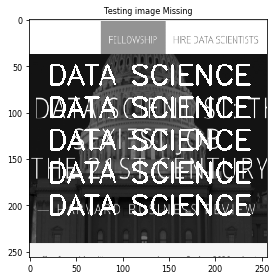

In [22]:
# put some text on y_test: y_test_missing
text = 'DATA SCIENCE'
font = cv.FONT_HERSHEY_SIMPLEX
fontScale = 1
# color = (255, 255, 255)
color = 1
thickness = 2
y_test_missing = y_test.copy()

for i in range(5):
    cv.putText(y_test_missing, text, (20, 70+i*35), font, fontScale, color, thickness, cv.LINE_AA)

fig, ax = plt.subplots(1, 1)
ax.imshow(y_test_missing, plt.cm.gray)
ax.set_title('Testing image Missing', fontsize = 8)
ax.set_xticklabels(np.uint8(np.linspace(0,300,7))-50, fontsize = 8)
ax.set_yticklabels(np.uint8(np.linspace(0,300,7))-50, fontsize = 8)
plt.tight_layout()
# plt.show()
fig.savefig("y_test_missing.png", dpi = 96, bbox_inches = 'tight')

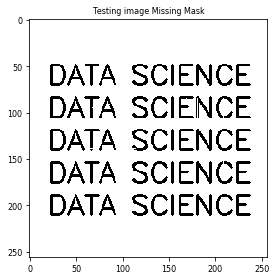

In [23]:
mask = np.floor(norm(y_test - y_test_missing))
# m_test_missing = 1 - (y_test - y_test_missing)
# for i in range(0, 256):
#     for j in range(0,256):
#         if m_test_missing[i,j] != 1:
#              m_test_missing[i,j] = 0
                             
fig, ax = plt.subplots(1, 1)
ax.imshow(mask, plt.cm.gray)
ax.set_title('Testing image Missing Mask', fontsize = 8)
ax.set_xticklabels(np.uint8(np.linspace(0,300,7))-50, fontsize = 8)
ax.set_yticklabels(np.uint8(np.linspace(0,300,7))-50, fontsize = 8)
plt.tight_layout()
fig.savefig("testing_image_missing_mask.png", dpi = 96, bbox_inches = 'tight')

In [24]:
#PSNR (y_test, y_test_missing), SSIM(y_test, y_test_missing)
PSNR1 = peak_signal_noise_ratio(y_test, y_test_missing)
print('PSNR (y_test, y_test_missing):', PSNR1)

SSIM1 = ssim(y_test, y_test_missing)
print('SSIM (y_test, y_test_missing):', SSIM1)

PSNR (y_test, y_test_missing): 10.94030859958922
SSIM (y_test, y_test_missing): 0.6472374448426783


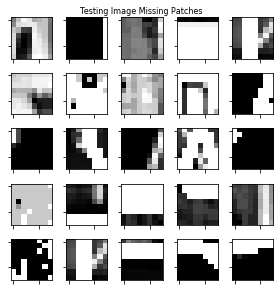

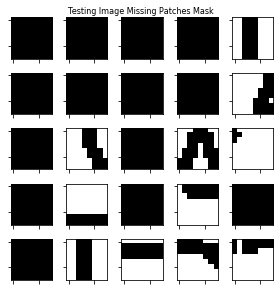

In [25]:
im_test = y_test.copy()
im_test_missing = y_test_missing.copy()
im_mask = mask

fig, ax = plt.subplots(5, 5, figsize = (4, 4))
fig2, ax2 = plt.subplots(5, 5, figsize = (4, 4))
for i in range(5):
     for j in range(5):
        rand = [np.random.randint(0, 32), np.random.randint(0, 32)]
        # print(i, j, rand)
        image_patch = im_test_missing[rand[0]*8:rand[0]*8+8, rand[1]*8:rand[1]*8+8]
        mask_patch = im_mask[rand[0]*8:rand[0]*8+8, rand[1]*8:rand[1]*8+8]
        ax[i][j].imshow(image_patch, plt.cm.gray)
        ax[i][j].set_xticklabels([])
        ax[i][j].set_yticklabels([])
        ax2[i][j].imshow(mask_patch, plt.cm.gray)
        ax2[i][j].set_xticklabels([])
        ax2[i][j].set_yticklabels([])
fig.suptitle('Testing Image Missing Patches', fontsize = 8, y = 1)
fig2.suptitle('Testing Image Missing Patches Mask', fontsize = 8, y = 1)
fig.tight_layout()
fig2.tight_layout()
plt.show()
fig.savefig("im_test_missing_patches_title.jpg", dpi = 96, bbox_inches = 'tight')
fig2.savefig("im_mask_missing_patches_title.jpg", dpi = 96, bbox_inches = 'tight')

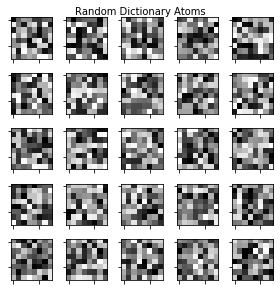

In [26]:
fig, ax = plt.subplots(5, 5,figsize = (4,4))
for i in range(5):
     for j in range(5):
        random_dict = np.random.random((8,8))
        ax[i][j].imshow(random_dict, plt.cm.gray)
        ax[i][j].set_xticklabels([])
        ax[i][j].set_yticklabels([])
fig.suptitle('Random Dictionary Atoms', fontsize = 10, y = 1)
fig.tight_layout()
plt.show()
fig.savefig("im_random_dict_title.jpg", dpi = 96, bbox_inches = 'tight')

PSNR (y_test, y_test_random): 10.431166988345844
SSIM (y_test, y_test_random): 0.4800246532904749


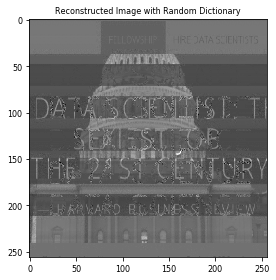

In [27]:
# Reconstruction Function
# flatten individual (8, 8) patch in to columns and store in new matrix
def flatten_patches(image):
    image_new = image.copy() # (256, 256)
    image_new_reshaped = image_new.reshape(64, 1024)
    y = image_new_reshaped.copy()
    for i in range(32):
        for j in range(32):
            patch = image_new[i*8:(i+1)*8, j*8:(j+1)*8]
            flatten_patch = patch.flat
            # update each column by the flattened (8,8) patch
            image_new_reshaped[:, i*32+j] = flatten_patch
    return image_new_reshaped

# Reconstruct a block patch using Orthogonal Matching Pursuit
def reconst_image(image, dictionary, mask, max_nonzero_elements = 20):
    # image_recons = np.empty_like(image)
    image = normalize(image)
    image_recons = np.zeros(image.shape)
    for i in range(32):
        for j in range(32):
            image_patch = image[i*8:(i+1)*8, j*8:(j+1)*8].flat
            mask_patch = mask[i*8:(i+1)*8, j*8:(j+1)*8].flat
            
            # returns the indices k of the pixel without mask (white region in mask)
            # white - 255, black - 0
            k = np.nonzero(mask_patch)[0]
            # normalize image patch
            image_patch_mean = np.mean(image_patch[k])
            image_patch_norm = np.linalg.norm(image_patch[k] - image_patch_mean)
            image_patch_normalized = (image_patch[k] - image_patch_mean)/image_patch_norm
           
            x_patch_sparse = orthogonal_mp(dictionary[k, :], 
                                        image_patch_normalized, 
                                        n_nonzero_coefs = max_nonzero_elements)
            # reconstructed patches
            recons_patch = dictionary.dot(x_patch_sparse)
            recons_patch = recons_patch * image_patch_norm + image_patch_mean
            recons_patch = recons_patch.reshape(8, 8)
            # concatenate patches together into original image size
            image_recons[i*8:(i+1)*8, j*8:(j+1)*8] = recons_patch[:, :]
    image_recons = norm(image_recons)
    return image_recons


# Reconstructed image from random dictionary and sparse matrix X obtained from OMP.
num_atom = 512
random_dict = np.random.random((64, num_atom))
# normalize the atoms in dict to have unit norm
random_dict = normalize(random_dict, axis = 0)
y_test_random= reconst_image(y_test_missing, random_dict, mask)

fig, ax = plt.subplots(1, 1)
ax.imshow(y_test_random, plt.cm.gray)
ax.set_title('Reconstructed Image with Random Dictionary', fontsize = 8)
ax.set_xticklabels(np.uint8(np.linspace(0,300,7))-50, fontsize = 8)
ax.set_yticklabels(np.uint8(np.linspace(0,300,7))-50, fontsize = 8)
plt.tight_layout()
# plt.show()
fig.savefig("reconstructed_image.png", dpi = 96, bbox_inches = 'tight')

#PSNR (y_test, y_test_missing), SSIM(y_test, y_test_missing)
PSNR2 = peak_signal_noise_ratio(y_test, y_test_random)
print('PSNR (y_test, y_test_random):', PSNR2)

SSIM2 = ssim(y_test, y_test_random)
print('SSIM (y_test, y_test_random):', SSIM2)

## K-SVD

### K-SVD Implementation

$$\underset{D,X}{\min}\,\,\|Y-DX\|_F^2\,\,\,\text{subject to}\,\,\,   \|x_i\|_0 \leq T_0,\,\,\forall i  $$

Solve $X$ by Orthogonal Matching Pursuit Algorithm

In [28]:
def dict_update(y, D, x, num_atom):
    #update dictionary using K-SVD
    for k in range(num_atom):
        # index of support of residue matrix E_k(supp)
        index = np.nonzero(x[k,:])[0]
        if len(index) == 0:
            continue
        # update k-th column in D
        D[:, k] = 0
        # E_k residue, keep the columns corresponding to non-zero elements in (x_k)T
        E_k = (y - np.dot(D, x))[:, index]
        # use SVD to update the dict and sparse_matrix
        U, S, V = np.linalg.svd(E_k, full_matrices = False)
        # use left most column of U to update dict
        D[:, k] = U[:, 0]
        # use 1st singular value and top row of V to update x
        x[k, index] = S[0] * V[0, :]
        #for i, j in enumerate(index):
        #    x[k, j] = S[0] * V[0, i]
    return D, x

Text(0, 0.5, 'Error')

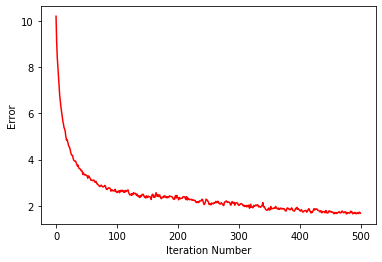

In [29]:
num_atom = 512
dictionary = np.random.random((64, num_atom))
dictionary = normalize(dictionary, axis = 0)
y_train_flatten = flatten_patches(y_train)
#print(y_train.shape, y_train_flatten.shape)

max_iter = 500
tolerance = 0.1
iteration_num = []
error = []
for i in range(max_iter):
    # sparse code
    x = orthogonal_mp(dictionary, y_train_flatten, n_nonzero_coefs = 20)
    e = np.linalg.norm(y_train_flatten - np.dot(dictionary, x))
    D, x = dict_update(y_train_flatten, dictionary, x, num_atom = 512)
    #print(str(i) + 'th iteration with error:' + str(e))
    if e < tolerance:
        break
    error.append(e)
    iteration_num.append(i)
plt.plot(iteration_num, error, 'r')
plt.xlabel('Iteration Number')
plt.ylabel('Error')
#x_sparse = linear_model.orthogonal_mp(dictionary, y_train_flatten)
#train_restruct = D.dot(x_sparse)

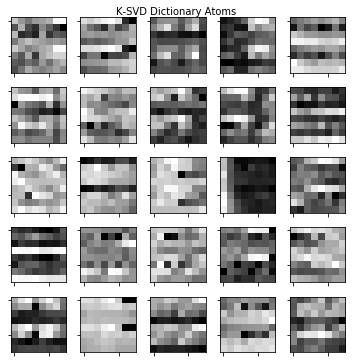

In [30]:
# Picture dictionary (25 smallest std columns)
dict_std = np.std(D, axis = 0)
dict_std_index = np.argsort(dict_std)

fig, ax = plt.subplots(5, 5, figsize = (5, 5))
for i in range(5):
     for j in range(5):
        index = i*5+j
        dic_patch = D[:, dict_std_index[index]].reshape((8, 8))
        ax[i][j].imshow(dic_patch, plt.cm.gray)
        ax[i][j].set_xticklabels([])
        ax[i][j].set_yticklabels([])
fig.suptitle('K-SVD Dictionary Atoms', fontsize = 10, y = 1)
fig.tight_layout()
plt.show()
fig.savefig("im_ksvd_dict_title.jpg", dpi = 96, bbox_inches = 'tight')

## K-SVD Reconstruction

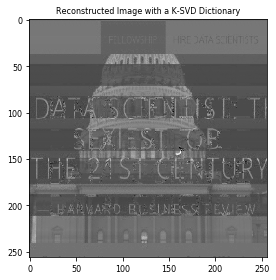

In [31]:
# reconstruct y_test
y_test_ksvd = reconst_image(y_test_missing, dictionary, mask)
y_test_ksvd = norm(y_test_ksvd)

fig, ax = plt.subplots(1, 1)
ax.imshow(y_test_ksvd, plt.cm.gray)
ax.set_title('Reconstructed Image with a K-SVD Dictionary', fontsize = 8)
ax.set_xticklabels(np.uint8(np.linspace(0,300,7))-50, fontsize = 8)
ax.set_yticklabels(np.uint8(np.linspace(0,300,7))-50, fontsize = 8)
plt.tight_layout()
# plt.show()
fig.savefig("reconstructed_image_ksvd.png", dpi = 96, bbox_inches = 'tight')

In [35]:
#PSNR (y_test, y_test_missing), SSIM(y_test, y_test_missing)

PSNR3 = peak_signal_noise_ratio(y_test, y_test_ksvd)
print('PSNR (y_test, y_test_ksvd):', PSNR3)

SSIM3 = ssim(y_test, y_test_ksvd)
print('SSIM (y_test, y_test_ksvd):', SSIM3)

PSNR (y_test, y_test_ksvd): 10.441888281599525
SSIM (y_test, y_test_ksvd): 0.4862123938992045


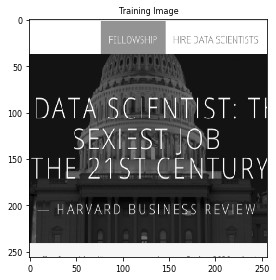

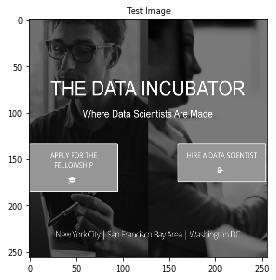

In [49]:
# Recover the first image:
image1 = io.imread('dataincubator_image_train.png')
image2 = io.imread('dataincubator_test.png')

#image1 = image1[:, 0: 2117, :]
image1 = cv.resize(image1, (256, 256))
y_train = color.rgb2gray(image1)
y_train = norm(y_train)

# image to recover
image2 = cv.resize(image2, (256, 256))
y_test = color.rgb2gray(image2)
y_test = norm(y_test)


# plot y_train
fig, ax = plt.subplots(1, 1)
ax.imshow(y_train, plt.cm.gray)
ax.set_title('Training Image', fontsize = 8)
ax.set_xticklabels(np.uint8(np.linspace(0,300,7))-50, fontsize = 8)
ax.set_yticklabels(np.uint8(np.linspace(0,300,7))-50, fontsize = 8)
plt.tight_layout()
fig.savefig("y_train.png", dpi = 96, bbox_inches = 'tight')

# plot y_test
fig, ax = plt.subplots(1, 1)
ax.imshow(y_test, plt.cm.gray)
ax.set_title('Test Image', fontsize = 8)
ax.set_xticklabels(np.uint8(np.linspace(0,300,7))-50, fontsize = 8)
ax.set_yticklabels(np.uint8(np.linspace(0,300,7))-50, fontsize = 8)
plt.tight_layout()
fig.savefig("y_test.png", dpi = 96, bbox_inches = 'tight')

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
[[0.42676528 0.42676528 0.42676528 ... 0.46282143 0.46282143 0.46394721]
 [0.42648008 0.42648008 0.42648008 ... 0.46282143 0.46282143 0.46677708]
 [0.42648008 0.42648008 0.42648008 ... 0.46282143 0.46282143 0.46677708]
 ...
 [0.07697538 0.07697538 0.07980526 ... 0.27952725 0.28036783 0.2831977 ]
 [0.07697538 0.07697538 0.08064583 ... 0.27725275 0.2755716  0.28036783]
 [0.07697538 0.07697538 0.07697538 ... 0.26396691 0.27075243 0.2679455 ]]


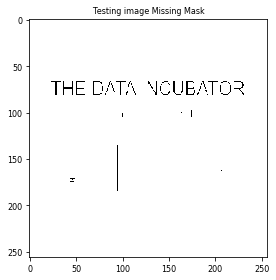

In [50]:
mask = np.floor(norm(y_test - 255))
# m_test_missing = 1 - (y_test - y_test_missing)
# for i in range(0, 256):
#     for j in range(0,256):
#         if m_test_missing[i,j] != 1:
#              m_test_missing[i,j] = 0
mask = 1 - mask        
print(mask)
print(y_test)

fig, ax = plt.subplots(1, 1)
ax.imshow(mask, plt.cm.gray)
ax.set_title('Testing image Missing Mask', fontsize = 8)
ax.set_xticklabels(np.uint8(np.linspace(0,300,7))-50, fontsize = 8)
ax.set_yticklabels(np.uint8(np.linspace(0,300,7))-50, fontsize = 8)
plt.tight_layout()
fig.savefig("DI_logo_mask.png", dpi = 96, bbox_inches = 'tight')

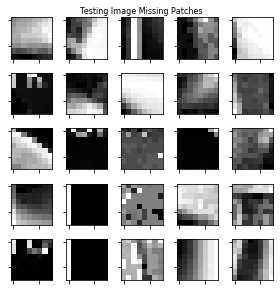

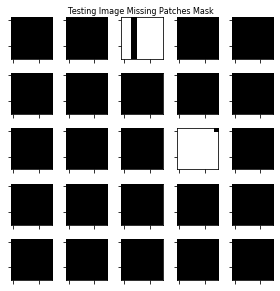

In [51]:
im_test = y_test.copy()
im_mask = mask

fig, ax = plt.subplots(5, 5, figsize = (4, 4))
fig2, ax2 = plt.subplots(5, 5, figsize = (4, 4))
for i in range(5):
     for j in range(5):
        rand = [np.random.randint(0, 32), np.random.randint(0, 32)]
        # print(i, j, rand)
        image_patch = im_test[rand[0]*8:rand[0]*8+8, rand[1]*8:rand[1]*8+8]
        mask_patch = im_mask[rand[0]*8:rand[0]*8+8, rand[1]*8:rand[1]*8+8]
        ax[i][j].imshow(image_patch, plt.cm.gray)
        ax[i][j].set_xticklabels([])
        ax[i][j].set_yticklabels([])
        ax2[i][j].imshow(mask_patch, plt.cm.gray)
        ax2[i][j].set_xticklabels([])
        ax2[i][j].set_yticklabels([])
fig.suptitle('Testing Image Missing Patches', fontsize = 8, y = 1)
fig2.suptitle('Testing Image Missing Patches Mask', fontsize = 8, y = 1)
fig.tight_layout()
fig2.tight_layout()
plt.show()
fig.savefig("im_test_missing_patches_title.jpg", dpi = 96, bbox_inches = 'tight')
fig2.savefig("im_mask_missing_patches_title.jpg", dpi = 96, bbox_inches = 'tight')

In [52]:
# Reconstruction Function
# flatten individual (8, 8) patch in to columns and store in new matrix
def flatten_patches(image):
    image_new = image.copy() # (256, 256)
    image_new_reshaped = image_new.reshape(64, 1024)
    y = image_new_reshaped.copy()
    for i in range(32):
        for j in range(32):
            patch = image_new[i*8:(i+1)*8, j*8:(j+1)*8]
            flatten_patch = patch.flat
            # update each column by the flattened (8,8) patch
            image_new_reshaped[:, i*32+j] = flatten_patch
    return image_new_reshaped

# Reconstruct a block patch using Orthogonal Matching Pursuit
def reconst_image_new(image, dictionary, mask, max_nonzero_elements = 20):
    # image_recons = np.empty_like(image)
    image = normalize(image)
    image_recons = np.zeros(image.shape)
    for i in range(32):
        for j in range(32):
            image_patch = image[i*8:(i+1)*8, j*8:(j+1)*8].flat
            image_patch = image[i*8:(i+1)*8, j*8:(j+1)*8].flat
            
            # returns the indices k of the pixel without mask (white region in mask)
            # white - 255, black - 0
            k = np.nonzero(mask_patch)[0]
            # normalize image patch
            image_patch_mean = np.mean(image_patch[k])
            image_patch_norm = np.linalg.norm(image_patch[k] - image_patch_mean)
            image_patch_normalized = (image_patch[k] - image_patch_mean)/image_patch_norm
           
            x_patch_sparse = orthogonal_mp(dictionary[k, :], 
                                        image_patch_normalized, 
                                        n_nonzero_coefs = max_nonzero_elements)
            # reconstructed patches
            recons_patch = dictionary.dot(x_patch_sparse)
            recons_patch = recons_patch * image_patch_norm + image_patch_mean
            recons_patch = recons_patch.reshape(8, 8)
            # concatenate patches together into original image size
            image_recons[i*8:(i+1)*8, j*8:(j+1)*8] = recons_patch[:, :]
    image_recons = norm(image_recons)
    return image_recons


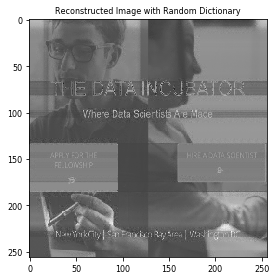

In [53]:
# Reconstructed image from random dictionary and sparse matrix X obtained from OMP.
num_atom = 512
random_dict2 = np.random.random((64, num_atom))
# normalize the atoms in dict to have unit norm
random_dict2 = normalize(random_dict2, axis = 0)
y_test_random2= reconst_image(y_test, random_dict, mask)

fig, ax = plt.subplots(1, 1)
ax.imshow(y_test_random2, plt.cm.gray)
ax.set_title('Reconstructed Image with Random Dictionary', fontsize = 8)
ax.set_xticklabels(np.uint8(np.linspace(0,300,7))-50, fontsize = 8)
ax.set_yticklabels(np.uint8(np.linspace(0,300,7))-50, fontsize = 8)
plt.tight_layout()
# plt.show()
fig.savefig("reconstructed_image.png", dpi = 96, bbox_inches = 'tight')


In [54]:
def dict_update(y, D, x, num_atom):
    #update dictionary using K-SVD
    for k in range(num_atom):
        # index of support of residue matrix E_k(supp)
        index = np.nonzero(x[k,:])[0]
        if len(index) == 0:
            continue
        # update k-th column in D
        D[:, k] = 0
        # E_k residue, keep the columns corresponding to non-zero elements in (x_k)T
        E_k = (y - np.dot(D, x))[:, index]
        # use SVD to update the dict and sparse_matrix
        U, S, V = np.linalg.svd(E_k, full_matrices = False)
        # use left most column of U to update dict
        D[:, k] = U[:, 0]
        # use 1st singular value and top row of V to update x
        x[k, index] = S[0] * V[0, :]
        #for i, j in enumerate(index):
        #    x[k, j] = S[0] * V[0, i]
    return D, x

0th iteration with error:15.63225803357901
1th iteration with error:13.559421265856336
2th iteration with error:13.01440948311866
3th iteration with error:12.094739976238632
4th iteration with error:11.777923063598289
5th iteration with error:10.947617971030473
6th iteration with error:10.643498011219403
7th iteration with error:10.289819711806159
8th iteration with error:10.00325453630801
9th iteration with error:9.396783473036743
10th iteration with error:9.3173782513861
11th iteration with error:8.742804165764067
12th iteration with error:8.55225323753295
13th iteration with error:8.103348611510697
14th iteration with error:7.836608201253333
15th iteration with error:7.726462370551191
16th iteration with error:7.443918796431463
17th iteration with error:7.33695554380022
18th iteration with error:7.225399083169515
19th iteration with error:7.146882521162692
20th iteration with error:7.049250911411119
21th iteration with error:6.984834173470004
22th iteration with error:6.573714308180

184th iteration with error:3.04320838448572
185th iteration with error:3.3139626129612454
186th iteration with error:3.2812597347174757
187th iteration with error:3.1798610885686345
188th iteration with error:2.8675931543778055
189th iteration with error:2.902094005779065
190th iteration with error:3.0158800690528653
191th iteration with error:3.0707917549881385
192th iteration with error:3.1114166277479796
193th iteration with error:3.0478097747486173
194th iteration with error:3.0423730119671553
195th iteration with error:3.0319629532613863
196th iteration with error:3.0539953657422427
197th iteration with error:3.0250849332046
198th iteration with error:3.110584351558262
199th iteration with error:2.923196242470559
200th iteration with error:2.936565587796529
201th iteration with error:3.042393250044969
202th iteration with error:2.968328547521333
203th iteration with error:3.055082205338876
204th iteration with error:2.9275459307003273
205th iteration with error:3.1298202976566025


Text(0, 0.5, 'Error')

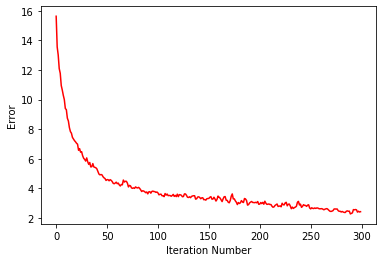

In [55]:
num_atom = 512
dictionary = np.random.random((64, num_atom))
dictionary = normalize(dictionary, axis = 0)
y_train_flatten = flatten_patches(y_train)

max_iter = 300
tolerance = 0.1
iteration_num = []
error = []
for i in range(max_iter):
    # sparse code
    x = orthogonal_mp(dictionary, y_train_flatten, n_nonzero_coefs = 20)
    e = np.linalg.norm(y_train_flatten - np.dot(dictionary, x))
    D, x = dict_update(y_train_flatten, dictionary, x, num_atom = 512)
    print(str(i) + 'th iteration with error:' + str(e))
    if e < tolerance:
        break
    error.append(e)
    iteration_num.append(i)
plt.plot(iteration_num, error, 'r')
plt.xlabel('Iteration Number')
plt.ylabel('Error')
#x_sparse = linear_model.orthogonal_mp(dictionary, y_train_flatten)
#train_restruct = D.dot(x_sparse)

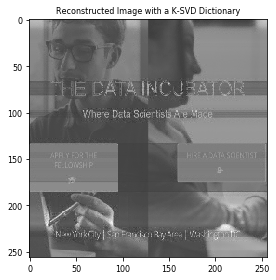

In [56]:
# reconstruct y_test
y_test_new_ksvd = reconst_image(y_test, dictionary, mask)
y_test_new_ksvd = norm(y_test_new_ksvd)

fig, ax = plt.subplots(1, 1)
ax.imshow(y_test_new_ksvd, plt.cm.gray)
ax.set_title('Reconstructed Image with a K-SVD Dictionary', fontsize = 8)
ax.set_xticklabels(np.uint8(np.linspace(0,300,7))-50, fontsize = 8)
ax.set_yticklabels(np.uint8(np.linspace(0,300,7))-50, fontsize = 8)
plt.tight_layout()
# plt.show()
fig.savefig("reconstructed_DI_image_ksvd.png", dpi = 96, bbox_inches = 'tight')